# **adapt*MLLM*&reg;**
*Evaluation and fine-tuning of Multilingual Language Models (MLLMs) and Large Language Models (LLMs) for translation of low-resource languages*

![DCU](https://github.com/seamusl/nmt/blob/main/logos/dcu.png?raw=true) ![MTU](https://github.com/seamusl/nmt/blob/main/logos/mtu.png?raw=true)




MIT License

##### © 2021 Adapt Centre, DCU / MTU, Ireland.
##### Author: Séamus Lankford  
##### seamus.lankford[at]adaptcentre.ie


Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

![MIT-license](https://github.com/seamusl/nmt/blob/main/logos/mit_license.png?raw=true)




## **Citation**

### **Using bibtex**

```
@misc{lankford_llm_2023,
 title={autoLLM}
 url={https://github.com/seamusl/autoLLM},
 publisher={Adapt Centre, Dublin City University},
 author={Lankford, Seamus}, year={2023}, month={Jan}
 }
```

### Using text citation

Lankford, S. (2023, January 01). autoLLM (Version 1.0) [Computer software]. Retrieved from https://github.com/seamusl/autoLLM

# **Initialization and hyperparameter configuration**

**Runtime configurations**
- Evaluation Mode:  
  - Hardware accelerator: None
  - Select Runtime Shape: High Ram
- Playground Mode:
  - Hardware accelerator: None
  - Select Runtime Shape: High Ram
- Fine-tuning Mode: **(Colab Pro+ subscription required)**
  - Hardware accelerator: GPU, GPU class: Premium
  - Select Runtime Shape: High Ram

In [ ]:
#@markdown ### Directory for results and models:
results_dir = "exp/LLM/mtsummit2021" #@param {type:"string"}

#@markdown ### Deloy model on HuggingFace:
hugging_deploy = False #@param {type:"boolean"}

#@markdown ### Run on Google Cloud
# run local option to be added in future release
cloud = True #@param {type:"boolean"}

if cloud:
  from google.colab import drive
  drive.mount('/content/drive')
  HOME='/content/drive/MyDrive'
else:
  HOME='~'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd $HOME/$results_dir

# Display GPU details provided by Google
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu \
    to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  print(gpu_info, file=open("experiment_log.txt", "a"))

/content/drive/MyDrive/exp/LLM/mtsummit2021
Mon Feb 13 10:35:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                            

In [ ]:
!pip install gpustat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 9.1 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19887 sha256=a89ea3f0f06f6de4ceca13ac7913b84ef443b43b69226a981f78caf5dfe48fba
  Stored in directory: /root/.cache/pip/wheels/1b/ed/14/0d513c962b25da841c42022cb5847c2ef835902c8563b8fb01
Successfully built gpustat
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
# display and log graphics using tidy gpustat format
!gpustat -P
!gpustat -P >> experiment_log.txt

dc75f16ec863              Mon Feb 13 10:35:17 2023  510.47.03
[0] NVIDIA A100-SXM4-40GB | 30°C,   0 %,   49 / 400 W |   424 / 40960 MB |


In [ ]:
if cloud:
  # Display RAM details
  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
  print('\n Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), \
        file=open("experiment_log.txt", "a"))

  if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime > \
          "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
  else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# set environment variables
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# use this version of transformers since
# pipline package not working with later version of transformers. Jan 3rd 2023
!pip install transformers==4.24

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.2 MB/s eta 0:00:00


In [ ]:
# sentencepiece is baked into the
!pip install datasets sacrebleu torch sentencepiece transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import transformers
print(transformers.__version__)

4.24.0


In [ ]:
#@title **Model Hyperparameters**

model_checkpoint = 'facebook/nllb-200-3.3B' #@param ["Helsinki-NLP/opus-mt-en-ro", "facebook/nllb-200-1.3B", "facebook/nllb-200-3.3B", "facebook/nllb-200-distilled-600M"]
s_lang = 'eng_Latn' #@param ["eng_Latn", "gle_Latn"]
t_lang = 'gle_Latn' #@param ["eng_Latn", "gle_Latn"]



#**Modes of operation:** choose which option to run

1.   [MLLM Fine Tuning](#scrollTo=iq6oBRz3n6qU&line=1&uniqifier=1)
1.   [MLLM Evaluation of Translation](#scrollTo=-xFN1OoX8WkW)
2.   [LLM Playgrounds](#scrollTo=0EYUWdoJ5QIg)
2.   [Human Evaluation](#scrollTo=mHLc8KkD4ESq)








# **Install dependencies and deepspeed. Configure deepspeed.**

In [ ]:
!pip install mpi4py
!pip install accelerate
!pip install transformers[deepspeed]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=5997315 sha256=12ed03bd5c0df1eefc16e1b8151632b0793a520aa67707647fa0db174acd4fc0
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.9/749.9 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) 

In [ ]:
# check that deepspeed correctly installed by running the report.
# Most configs are installed on the fly later
!ds_report

--------------------------------------------------
DeepSpeed C++/CUDA extension op report
--------------------------------------------------
NOTE: Ops not installed will be just-in-time (JIT) compiled at
      runtime if needed. Op compatibility means that your system
      meet the required dependencies to JIT install the op.
--------------------------------------------------
JIT compiled ops requires ninja
ninja .................. [OKAY]
--------------------------------------------------
op name ................ installed .. compatible
--------------------------------------------------
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
async_io ............... [NO] ....... [NO]
cpu_adagrad ............ [NO] ....... [OKAY]
cpu_a

In [ ]:
## Declare DeepSpeed Config ##

ds_config_dict = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 5e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [ ]:
import torch
print(torch.__version__)

1.13.1+cu116


# **Load datasets**

In [ ]:
#@markdown ### Upload datasets in json format
json_upload = False #@param {type:"boolean"}

%cd $HOME/$results_dir
# if datasets not already organised into json, they must be converted to json

if json_upload == False:
# following package, hone, can be used for conversion:
  !pip install hone
  !hone train.csv train.json
  !hone validation.csv validation.json
  !hone test.csv test.json

# alternatively the following free online tool can be used
# https://www.convertcsv.io/

if json_upload == True:
  from google.colab import files

  print("*** Upload train.json ***")
  uploaded = files.upload()
  filename = next(iter(uploaded))
  !chmod +x $filename

  print("*** Upload validation.json ***")
  uploaded = files.upload()
  filename = next(iter(uploaded))
  !chmod +x $filename

  print("*** Upload test.json ***")
  uploaded = files.upload()
  filename = next(iter(uploaded))
  !chmod +x $filename



In [ ]:
from datasets import load_dataset
%cd $HOME/$results_dir
my_datasets = load_dataset("json", data_files={"train": "train.json",
                                               "validation": "validation.json",
                                               "test": "test.json"})

/content/drive/MyDrive/exp/LLM/mtsummit2021


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-50a8d683f8aec43c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

**Check the shape of the datasets dictionary and sample content within one of the datasets**

In [ ]:
my_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 13171
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 502
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 357
    })
})

In [ ]:
my_datasets["train"][:2]

{'translation': [{'en': 'How do covid-19', 'ga': 'Cén chaoi a n-oibríonn'},
  {'en': 'Vaccines work?', 'ga': 'Vacsaíní covid-19?'}]}

**Randomly pick samples from dataset to see format of data.**

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Choose less elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
show_random_elements(my_datasets["train"])

,translation
0,"{'en': 'Online Collaboration:', 'ga': 'Comhoibriú Ar Líne:'}"
1,"{'en': 'The virus can be found from a surface that has been infected or sneezed by a person with the virus.', 'ga': 'Is féidir an víreas a fháil ó dhromhchla a ndearna duine leis an víreas casacht nó sraothartach air.'}"
2,"{'en': 'In summary, the role of the LWR is to:', 'ga': 'Go hachomair, is é ról Príomhionadaí na nOibrithe:'}"
3,"{'en': '3 march', 'ga': '3 márta'}"
4,"{'en': 'The association of secondary teachers, ireland (asti) withdrew from discussions with the department of education on the leaving certificate 2021 after it said that the plan being developed would not provide a ""meaningful leaving certificate"" for students.', 'ga': 'Tharraing cumann na múinteoirí meánscoile, éire (asti) siar ó phlé leis an roinn oideachais ar ardteistiméireacht 2021 tar éis a rá nach gcuirfeadh an plean atá á fhorbairt “ardteistiméireacht bhríoch ” ar fáil do mhic léinn.'}"


In [ ]:
from datasets import load_metric
metric = load_metric("sacrebleu")
metric

<ipython-input-19-82d0f627332f>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

# **Preprocess data**

The Transformers tokenizer tokenises the inputs (including converting tokens to their corresponding IDs in the pretrained vocabulary).

- the tokenizer is instantiated with the AutoTokenizer.from_pretrained method
- the tokenizer must correspond to the model architecture being used
- download the vocabulary used when pretraining the chosen checkpoint
- the vocabulary is cached


In [ ]:
from transformers import NllbTokenizer

tokenizer = NllbTokenizer.from_pretrained(
model_checkpoint, src_lang=s_lang, tgt_lang=t_lang)

**The tokenizer can be called directly on a sentence or a pair of sentences:**

In [ ]:
tokenizer(["This is a sample sentence.", "This is another example."])

{'input_ids': [[9680, 248, 9, 183824, 109267, 248075, 2, 256047], [9680, 248, 28911, 47535, 248075, 2, 256047]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

To prepare targets for our model, they need to be tokenised inside the as_target_tokenizer context manager:
- ensures the tokenizer uses the special tokens corresponding to the targets

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))


{'input_ids': [[94124, 248079, 3423, 4990, 109267, 248203, 2, 256061], [9680, 248, 28911, 109267, 248075, 2, 256061]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


The following function preprocess our samples:
- send them to the tokenizer with the argument truncation=True
- longer inputs truncated to the maximum length accepted by the model
- padding is handled in a data collator (see later cell)
- examples are padded to the longest length in the batch

In [ ]:
# First row of JSON data files should be modified with eng_Latn and gle_Latn
# use standard names throughout => remove source_lang and target_lang variables

prefix = ""
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "ga"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    # labels = tokenizer(text_target=targets, padding=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

The function is passed over all sentence pairs in the dataset by applying the map method of the dataset object which was created earlier. This applies the function on all elements in the training, validation and testing dataset splits (with just a single command).


In [ ]:
preprocess_function(my_datasets['train'][:2])

{'input_ids': [[13374, 359, 55196, 85, 7737, 2, 256047], [171139, 204820, 10527, 248130, 2, 256047]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]], 'labels': [[109397, 208587, 9, 5, 248105, 169123, 148398, 2, 256061], [171139, 209, 66727, 55196, 85, 7737, 248130, 2, 256061]]}

In [ ]:
tokenized_datasets = my_datasets.map(preprocess_function, batched=True)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
%cd $HOME/$results_dir
model_name = model_checkpoint.split("/")[-1]
model_dir = f"{model_name}-finetuned-{source_lang}-to-{target_lang}"

/content/drive/MyDrive/exp/LLM/mtsummit2021


In [ ]:
'''
With pytorch, need to use tensorboardX instead of tensorboard for visualisation
https://github.com/lanpa/tensorboardX
https://tensorboardx.readthedocs.io/en/latest/tutorial.html
https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/utils/statistics.py
'''
%cd $HOME/$results_dir/runs

!pip3 install tensorboardX &> /dev/null

%load_ext tensorboard
%tensorboard --logdir .

# **Fine-tune the model**

Once the data has been preprocessed, the pretrained model is downloaded and fine-tuned. The AutoModelForSeq2SeqLM class is used since the task is  sequence-to-sequence. Similar to tokenizer, the from_pretrained method downloads and caches the model.

In [ ]:
%cd $HOME/$results_dir

#@title Model Hyperparameters

my_epochs = 8 #@param {type:"slider", min:1, max:10, step:1}
my_batch_size = 16 #@param {type:"slider", min:8, max:32, step:4}
my_gradient_accumulation_steps = 5 #@param {type:"slider", min:1, max:12, step:1}
my_learning_rate = 0.00002 #@param {type:"slider", min:0.00001, max:0.00009, step:0.00001}
my_weight_decay = 0.01 #@param {type:"slider", min:0.01, max:2.0, step:0.1}
my_mixed_precision = True #@param {type:"boolean"}

my_seed = 535353 #@param {type:"integer"}

with open('experiment_log.txt', 'a') as f:
    f.write("\n + Model Training Parameters + \n")

    f.write("\n Number of Epochs: ")
    f.write(str(my_epochs))

    f.write("\n Batch size: ")
    f.write(str(my_batch_size))

    f.write("\n Gradient accumulation steps: ")
    f.write(str(my_gradient_accumulation_steps))

    f.write("\n Learning rate: ")
    f.write(str(my_learning_rate))

    f.write("\n Weight Decay: ")
    f.write(str(my_weight_decay))

    f.write("\n Model checkpoint: ")
    f.write(str(model_checkpoint))

    f.write("\n Source lanuage: ")
    f.write(str(s_lang))

    f.write("\n Target language: ")
    f.write(str(t_lang))


/content/drive/MyDrive/exp/LLM/mtsummit2021


In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
# DeepSpeed requires a distributed environment even when only one process is used.
# This emulates a launcher in the notebook
import os

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

To instantiate a Seq2SeqTrainer, the [Seq2SeqTrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments) must be setup.
This class contains all the attributes needed to customise training. It requires one folder name, which is used to save the checkpoints of the model.The other arguments are optional.

In [ ]:
%cd $HOME/$results_dir
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=my_learning_rate,
    per_device_train_batch_size=my_batch_size,
    per_device_eval_batch_size=my_batch_size,
    weight_decay=my_weight_decay,
    save_total_limit=8,
    num_train_epochs=my_epochs,
    fp16=my_mixed_precision,
    gradient_accumulation_steps=my_gradient_accumulation_steps,
    # set logging parameter for storing logs from metric function
    logging_dir=os.getcwd(),
    seed=my_seed,
    predict_with_generate=True,
    deepspeed=ds_config_dict
)

/content/drive/MyDrive/exp/LLM/mtsummit2021
[2023-02-13 10:44:14,825] [INFO] [comm.py:657:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our Seq2SeqTrainer is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [ ]:
import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using cuda_amp half precision backend


In [ ]:
import time

# log the length of time taken to build model
start_train = time.time()

# start llm training
trainer.train()

end_train = time.time()
train_time = int(end_train - start_train)
print("+ Model Training Time + \n" + str(train_time))
print("+ Model Training Time + \n" + str(train_time),
      file=open("experiment_log.txt", "a"))

The following columns in the training set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.


[2023-02-13 10:44:14,905] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed info: version=0.8.0, git-hash=unknown, git-branch=unknown
[2023-02-13 10:44:22,315] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /root/.cache/torch_extensions/py38_cu116 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py38_cu116/cpu_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py38_cu116/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


Time to load cpu_adam op: 36.43426561355591 seconds
[2023-02-13 10:45:06,319] [INFO] [logging.py:68:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2023-02-13 10:45:06,499] [INFO] [logging.py:68:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2023-02-13 10:45:06,500] [INFO] [utils.py:52:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2023-02-13 10:45:06,501] [INFO] [logging.py:68:log_dist] [Rank 0] Creating fp16 ZeRO stage 2 optimizer
[2023-02-13 10:45:06,502] [INFO] [stage_1_and_2.py:141:__init__] Reduce bucket size 500000000
[2023-02-13 10:45:06,503] [INFO] [stage_1_and_2.py:142:__init__] Allgather bucket size 200000000
[2023-02-13 10:45:06,504] [INFO] [stage_1_and_2.py:143:__init__] CPU Offload: True
[2023-02-13 10:45:06,508] [INFO] [stage_1_and_2.py:144:__init__] Round robin gradient partitioning: False


Using /root/.cache/torch_extensions/py38_cu116 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py38_cu116/utils...
Emitting ninja build file /root/.cache/torch_extensions/py38_cu116/utils/build.ninja...
Building extension module utils...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module utils...


Time to load utils op: 18.641969919204712 seconds
Rank: 0 partition count [1] and sizes[(3344863232, False)] 
[2023-02-13 10:45:40,164] [INFO] [utils.py:831:see_memory_usage] Before initializing optimizer states
[2023-02-13 10:45:40,166] [INFO] [utils.py:832:see_memory_usage] MA 7.22 GB         Max_MA 7.22 GB         CA 7.23 GB         Max_CA 7 GB 
[2023-02-13 10:45:40,168] [INFO] [utils.py:840:see_memory_usage] CPU Virtual Memory:  used = 23.59 GB, percent = 28.3%
[2023-02-13 10:45:55,937] [INFO] [utils.py:831:see_memory_usage] After initializing optimizer states
[2023-02-13 10:45:55,949] [INFO] [utils.py:832:see_memory_usage] MA 7.22 GB         Max_MA 7.22 GB         CA 7.23 GB         Max_CA 7 GB 
[2023-02-13 10:45:55,960] [INFO] [utils.py:840:see_memory_usage] CPU Virtual Memory:  used = 77.36 GB, percent = 92.7%
[2023-02-13 10:45:55,962] [INFO] [stage_1_and_2.py:522:__init__] optimizer state initialized
[2023-02-13 10:45:56,281] [INFO] [utils.py:831:see_memory_usage] After initial

Using /root/.cache/torch_extensions/py38_cu116 as PyTorch extensions root...
No modifications detected for re-loaded extension module utils, skipping build step...
Loading extension module utils...
***** Running training *****
  Num examples = 13171
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 5
  Total optimization steps = 1312
  Number of trainable parameters = 3344863232


Time to load utils op: 0.0031890869140625 seconds
[2023-02-13 10:46:07,494] [INFO] [stage_1_and_2.py:1762:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536, reducing to 65536


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
0,No log,1.308594,22.601100,31.657400
1,No log,1.217773,22.225100,31.364500
2,No log,1.154297,21.662000,31.286900
3,1.160000,1.118164,25.400200,32.055800
4,1.160000,1.112305,26.064300,32.043800
5,1.160000,1.144531,25.920300,32.695200
6,0.631700,1.150391,26.509900,32.292800
7,0.631700,1.169922,26.850100,32.816700


[2023-02-13 10:46:14,004] [INFO] [stage_1_and_2.py:1762:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 65536, reducing to 32768.0
[2023-02-13 10:46:20,525] [INFO] [stage_1_and_2.py:1762:step] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768.0, reducing to 16384.0


The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 502
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 502
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num e

[2023-02-13 12:03:00,020] [INFO] [logging.py:68:log_dist] [Rank 0] [Torch] Checkpoint global_step502 is begin to save!
[2023-02-13 12:03:00,041] [INFO] [logging.py:68:log_dist] [Rank 0] Saving model checkpoint: nllb-200-3.3B-finetuned-en-to-ga/checkpoint-500/global_step502/mp_rank_00_model_states.pt
[2023-02-13 12:03:00,042] [INFO] [torch_checkpoint_engine.py:15:save] [Torch] Saving nllb-200-3.3B-finetuned-en-to-ga/checkpoint-500/global_step502/mp_rank_00_model_states.pt...


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


[2023-02-13 12:03:24,707] [INFO] [torch_checkpoint_engine.py:17:save] [Torch] Saved nllb-200-3.3B-finetuned-en-to-ga/checkpoint-500/global_step502/mp_rank_00_model_states.pt.
[2023-02-13 12:03:24,736] [INFO] [torch_checkpoint_engine.py:15:save] [Torch] Saving nllb-200-3.3B-finetuned-en-to-ga/checkpoint-500/global_step502/zero_pp_rank_0_mp_rank_00_optim_states.pt...
[2023-02-13 12:05:26,961] [INFO] [torch_checkpoint_engine.py:17:save] [Torch] Saved nllb-200-3.3B-finetuned-en-to-ga/checkpoint-500/global_step502/zero_pp_rank_0_mp_rank_00_optim_states.pt.
[2023-02-13 12:05:27,166] [INFO] [engine.py:3397:_save_zero_checkpoint] zero checkpoint saved nllb-200-3.3B-finetuned-en-to-ga/checkpoint-500/global_step502/zero_pp_rank_0_mp_rank_00_optim_states.pt
[2023-02-13 12:05:27,168] [INFO] [torch_checkpoint_engine.py:27:commit] [Torch] Checkpoint global_step502 is ready now!


The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 502
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 502
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num e

[2023-02-13 13:23:22,644] [INFO] [logging.py:68:log_dist] [Rank 0] [Torch] Checkpoint global_step1004 is begin to save!
[2023-02-13 13:23:22,659] [INFO] [logging.py:68:log_dist] [Rank 0] Saving model checkpoint: nllb-200-3.3B-finetuned-en-to-ga/checkpoint-1000/global_step1004/mp_rank_00_model_states.pt
[2023-02-13 13:23:22,660] [INFO] [torch_checkpoint_engine.py:15:save] [Torch] Saving nllb-200-3.3B-finetuned-en-to-ga/checkpoint-1000/global_step1004/mp_rank_00_model_states.pt...
[2023-02-13 13:23:47,153] [INFO] [torch_checkpoint_engine.py:17:save] [Torch] Saved nllb-200-3.3B-finetuned-en-to-ga/checkpoint-1000/global_step1004/mp_rank_00_model_states.pt.
[2023-02-13 13:23:47,159] [INFO] [torch_checkpoint_engine.py:15:save] [Torch] Saving nllb-200-3.3B-finetuned-en-to-ga/checkpoint-1000/global_step1004/zero_pp_rank_0_mp_rank_00_optim_states.pt...
[2023-02-13 13:25:49,365] [INFO] [torch_checkpoint_engine.py:17:save] [Torch] Saved nllb-200-3.3B-finetuned-en-to-ga/checkpoint-1000/global_step

The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 502
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `M2M100ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `M2M100ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 502
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




+ Model Training Time + 
12631


In [ ]:
# save all metrics
# trainer.log_metrics

In [ ]:
# save the final model
trainer.save_model("./my_final_model")

Saving model checkpoint to ./my_final_model
Configuration saved in ./my_final_model/config.json
Model weights saved in ./my_final_model/pytorch_model.bin
tokenizer config file saved in ./my_final_model/tokenizer_config.json
Special tokens file saved in ./my_final_model/special_tokens_map.json


In [ ]:
trainer.save_metrics("all", metrics)

# **Plot Training of Model**

The `Trainer` class records the log history. It can be used to access the train and validation losses recorded at each `logging_steps` during training. Since we are fine-tuning a language model, we want to compute the perplexity. We can look at the perplexity plot in the same way we look at the loss plot: the lower the better and if the validation perplexity starts to increase we are starting to overfit the model.


In [ ]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 31.0 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.


/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


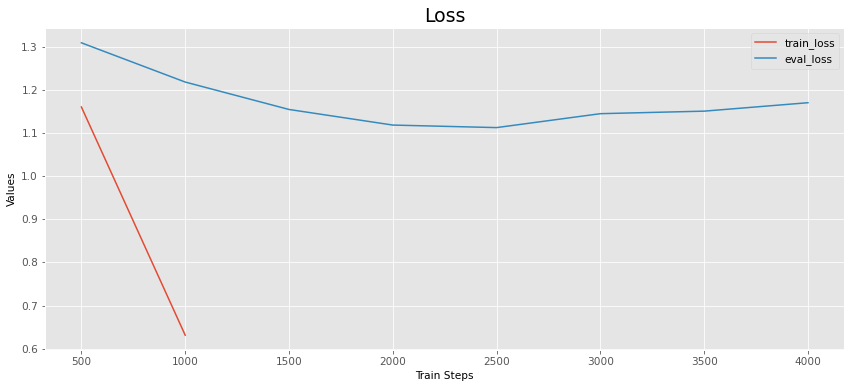

/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


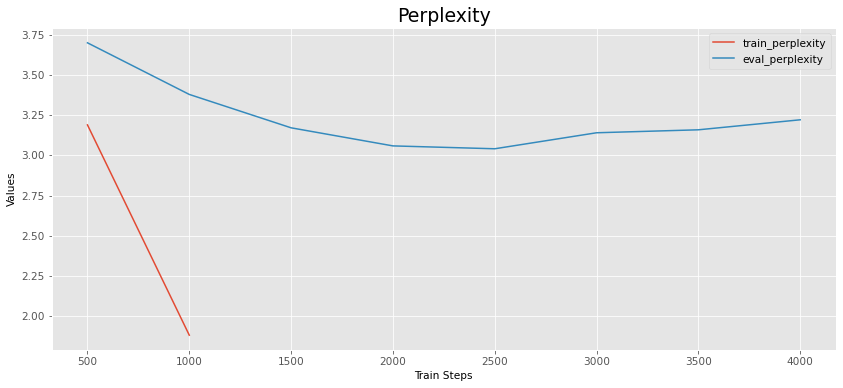

In [ ]:
# https://colab.research.google.com/github/gmihaila/ml_things/blob/master/notebooks/pytorch/pretrain_transformers_pytorch.ipynb#scrollTo=qSuUpkj1UuUa
# Keep track of train and evaluate loss.

import math

from ml_things import plot_dict

loss_history = {'train_loss':[], 'eval_loss':[]}

# Keep track of train and evaluate perplexity.
# This is a metric useful to track for language models.
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with training loss.
    loss_history['train_loss'].append(log_history['loss'])
    perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))

# Plot Losses.
plot_dict(loss_history, start_step=args.logging_steps,
          step_size=args.logging_steps, use_title='Loss',
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

print()

# Plot Perplexities.
plot_dict(perplexity_history, start_step=args.logging_steps,
          step_size=args.logging_steps, use_title='Perplexity',
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

# **Deploy model (& card) to HuggingFace hub**
<!--   
![huggingface](https://github.com/seamusl/nmt/blob/main/logos/huggingface.png?raw=true)

Text -->

In [ ]:
# Use the transformers-cli to create repo on hugging face hub:
# https://huggingface.co/transformers/v2.3.0/model_sharing.html
!huggingface-cli login

In [ ]:
#@title Repo name on HuggingFace

name_of_repo = 'specify a name for the repo' #@param {type:"string"}
!huggingface-cli repo create name_of_repo

In [ ]:
trainer.push_to_hub(name_of_repo)

#$\color{green}{\text{The Green Report}}$#

<!-- Text -->  
<!--   

![huggingface](https://github.com/seamusl/nmt/blob/main/logos/gogreen.png?raw=true)

Text -->

In [ ]:
Country = 'Europe' #@param ["Africa", "Argentina", "Armenia", "Asia", "Australia", "Austria", "Azerbaijan", "Bangladesh", "Belarus", "Belgium", "Bolivia", "Bosnia and Herzegovina", "Brazil","Bulgaria", "Burundi", "Canada", "Chile", "China", "Costa Rica",	"Croatia", "Cyprus", "Czechia", "Denmark", "Ecuador", "Egypt", "El Salvador", "Estonia", "Europe", "European Union (27)", "Finland", "France", "G20 (Ember)", "G7 (Ember)", "Georgia", "Germany", "Greece",	"High-income countries",	"Hungary", "India", "Ireland", "Italy", "Japan", "Kazakhstan", "Kenya", "Latin America and Caribbean (Ember)", "Latvia", "Lithuania",	 "Low-income countries", "Lower-middle-income countries", "Luxembourg", "Malaysia", "Malta", "Mexico", "Middle East (Ember)", "Moldova", "Mongolia", "Montenegro", "Netherlands", "New Zealand", "North America", "North Macedonia",	 "Norway", "OECD (Ember)",	 "Oceania", "Pakistan", "Peru", "Philippines", "Poland", "Portugal", "Romania", "Russia", "Saudi Arabia", "Senegal", "Serbia", "Singapore", "Slovakia", "Slovenia", "South Africa", "South America", "South Korea",	 "Spain", "Sweden", "Switzerland", "Taiwan", "Tajikistan", "Thailand", "Tunisia", "Turkey", "Ukraine", "United Kingdom", "United States", "Upper-middle-income countries",	 "Uruguay", "Vietnam", "World"]
print(Country)

import pandas as pd
data = pd.Series([287.1018066, 347.2919617, 206.9425812, 476.8709106, 486.2549744, 81.25418091, 481.5190735, 446.6684265, 443.6255798, 139.7274017, 311.4754028, 478.4580383, 141.7742615, 419.3927307, 312.5, 118.9966812, 374.4632263, 541.3317261, 30.90332603, 131.2670898, 587.4980469, 412.2454834, 149.746048, 137.5482483, 389.019104, 245.8269958, 739.8695068, 269.8972168, 259.7529907, 68.83359528, 58.47919846, 444.8736267, 337.6940002, 111.3744049, 352.4225159, 430.258667, 320.9462585, 195.5025482, 626.0070801, 381.0868835, 222.8386993, 416.4961853, 654.9423828, 112.3792801, 260.0820923, 171.6111908, 209.0308228, 312.5, 412.5871582, 0, 541.0005493, 406.5040588, 373.8074646, 527.3986206,	 629.8568115, 725.9740601, 350.684906, 328.9040833, 135.9849701, 324.8181763, 349.1140747, 25.08072281, 338.2880249, 436.3691711, 295.7744751, 233.979248, 544.3023071, 727.7764893, 181.1025696, 252.8423615, 336.4832458, 568.500061, 534.4202881, 545.552002, 463.896637, 100.8578186, 250.8790588, 664.7375488, 166.1847839, 423.8267517, 169.0344543, 11.77053738, 57.77264404, 567.4732056, 83.28968811, 503.1549377, 470.3814697, 429.6387939, 240.5024109, 264.5090942, 357.2020874, 482.1105652, 152.3871613, 426.2657776, 425.2348633],
                 index=['Africa', 'Argentina', 'Armenia', 'Asia',	'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burundi', 'Canada', 'Chile', 'China	', 'Costa Rica',	'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Europe', 'European Union (27)', 'Finland', 'France', 'G20 (Ember)', 'G7 (Ember)', 'Georgia', 'Germany', 'Greece', 'High-income countries', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Kazakhstan', 'Kenya', 'Latin America and Caribbean (Ember)', 'Latvia', 'Lithuania', 'Low-income countries', 'Lower-middle-income countries', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico', 'Middle East (Ember)', 'Moldova', 'Mongolia', 'Montenegro', 'Netherlands', 'New Zealand', 'North America', 'North Macedonia', 'Norway', 'OECD (Ember)', 'Oceania', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South America', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Tajikistan', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine', 'United Kingdom', 'United States', 'Upper-middle-income countries', 'Uruguay', 'Vietnam', 'World'])

# gCO2 per kWh
gCO2 = data[Country]
print(gCO2)
print("Source: https://ourworldindata.org/grapher/carbon-intensity-electricity")


Europe
269.8972168
Source: https://ourworldindata.org/grapher/carbon-intensity-electricity


In [ ]:
# Get total running time in seconds for model build, t_pwr
# Calculate (t_pwr / 3600) * 0.001 to get kWh for model build
# Take user-input for gCO2 for each kWh using their provided country
# Display total power consumption for model build and kgCO2 consumed
# Log total power consumption for model build and kgCO2 consumed

gpu = !nvidia-smi --query-gpu=count --format=csv,noheader
n_gpu = int(gpu[0])
print(n_gpu)

for g in range(0, n_gpu):
  print(g)
  pwr = !nvidia-smi -i $g --query-gpu=power.draw --format=csv,noheader,nounits
  f_pwr = float(pwr[0])
  t_pwr =+ f_pwr

# power draw per second across all gpus
print(t_pwr)

# training time im seconds calculated from previous cell
# total power draw during model build

model_power = t_pwr * train_time
model_power_kWh = (model_power / 3600) * 0.001

t_kgCO2 = (model_power_kWh * gCO2) * 0.001


print("\n kgCO2 Emission during model development: ", round((t_kgCO2),2))
print("\n kgCO2 Emission during model development: ", round((t_kgCO2),2),
      file=open("experiment_log.txt", "a"))

print("\n Total kWh power used in model development: ", round((model_power_kWh),2))
print("\n Total kWh power used in model development: ", round((model_power_kWh),2),
      file=open("experiment_log.txt", "a"))


# **MLLM Evaluation of Translation**

## **NLLB MLLM Translation**
![nllb_small](https://github.com/seamusl/nmt/blob/main/logos/nllb_small.png?raw=true)

In [ ]:
#@markdown ### Specify the directory which holds model & config:
#@markdown Model can be local finetuned model or pretrained from HuggingFace hub:
my_model = "/content/drive/MyDrive/exp/LLM/mtsummit2021/my_final_model"
# my_model = "facebook/nllb-200-3.3B" #@param ["facebook/nllb-200-distilled-600M", "facebook/nllb-200-1.3B", "facebook/nllb-200-distilled-1.3B", "facebook/nllb-200-3.3B"] {allow-input: true}
source = 'eng_Latn' #@param ["ace_Arab", "ace_Latn", "acm_Arab", "acq_Arab", "aeb_Arab", "afr_Latn", "ajp_Arab", "aka_Latn", "amh_Ethi", "apc_Arab", "arb_Arab", "arb_Latn", "ars_Arab", "ary_Arab", "arz_Arab", "asm_Beng", "ast_Latn", "awa_Deva", "ayr_Latn", "azb_Arab", "azj_Latn", "bak_Cyrl", "bam_Latn", "ban_Latn", "bel_Cyrl", "bem_Latn", "ben_Beng", "bho_Deva", "bjn_Arab", "bjn_Latn", "bod_Tibt", "bos_Latn", "bug_Latn", "bul_Cyrl", "cat_Latn", "ceb_Latn", "ces_Latn", "cjk_Latn", "ckb_Arab", "crh_Latn", "cym_Latn", "dan_Latn", "deu_Latn", "dik_Latn", "dyu_Latn", "dzo_Tibt", "ell_Grek", "eng_Latn", "epo_Latn", "est_Latn", "eus_Latn", "ewe_Latn", "fao_Latn", "fij_Latn", "fin_Latn", "fon_Latn", "fra_Latn", "fur_Latn", "fuv_Latn", "gla_Latn", "gle_Latn", "glg_Latn", "grn_Latn", "guj_Gujr", "hat_Latn", "hau_Latn", "heb_Hebr", "hin_Deva", "hne_Deva", "hrv_Latn", "hun_Latn", "hye_Armn", "ibo_Latn", "ilo_Latn", "ind_Latn", "isl_Latn", "ita_Latn", "jav_Latn", "jpn_Jpan", "kab_Latn", "kac_Latn", "kam_Latn", "kan_Knda", "kas_Arab", "kas_Deva", "kat_Geor", "knc_Arab", "knc_Latn", "kaz_Cyrl", "kbp_Latn", "kea_Latn", "khm_Khmr", "kik_Latn", "kin_Latn", "kir_Cyrl", "kmb_Latn", "kmr_Latn", "kon_Latn", "kor_Hang", "lao_Laoo", "lij_Latn", "lim_Latn", "lin_Latn", "lit_Latn", "lmo_Latn", "ltg_Latn", "ltz_Latn", "lua_Latn", "lug_Latn", "luo_Latn", "lus_Latn", "lvs_Latn", "mag_Deva", "mai_Deva", "mal_Mlym", "mar_Deva", "min_Arab", "min_Latn", "mkd_Cyrl", "plt_Latn", "mlt_Latn", "mni_Beng", "khk_Cyrl", "mos_Latn", "mri_Latn", "mya_Mymr", "nld_Latn", "nno_Latn", "nob_Latn", "npi_Deva", "nso_Latn", "nus_Latn", "nya_Latn", "oci_Latn", "gaz_Latn", "ory_Orya", "pag_Latn", "pan_Guru", "pap_Latn", "pes_Arab", "pol_Latn", "por_Latn", "prs_Arab", "pbt_Arab", "quy_Latn", "ron_Latn", "run_Latn", "rus_Cyrl", "sag_Latn", "san_Deva", "sat_Olck", "scn_Latn", "shn_Mymr", "sin_Sinh", "slk_Latn", "slv_Latn", "smo_Latn", "sna_Latn", "snd_Arab", "som_Latn", "sot_Latn", "spa_Latn", "als_Latn", "srd_Latn", "srp_Cyrl", "ssw_Latn", "sun_Latn", "swe_Latn", "swh_Latn", "szl_Latn", "tam_Taml", "tat_Cyrl", "tel_Telu", "tgk_Cyrl", "tgl_Latn", "tha_Thai", "tir_Ethi", "taq_Latn", "taq_Tfng", "tpi_Latn", "tsn_Latn", "tso_Latn", "tuk_Latn", "tum_Latn", "tur_Latn", "twi_Latn", "tzm_Tfng", "uig_Arab", "ukr_Cyrl", "umb_Latn", "urd_Arab", "uzn_Latn", "vec_Latn", "vie_Latn", "war_Latn", "wol_Latn", "xho_Latn", "ydd_Hebr", "yor_Latn", "yue_Hant", "zho_Hans", "zho_Hant", "zsm_Latn", "zul_Latn"]
target = 'gle_Latn' #@param ["ace_Arab", "ace_Latn", "acm_Arab", "acq_Arab", "aeb_Arab", "afr_Latn", "ajp_Arab", "aka_Latn", "amh_Ethi", "apc_Arab", "arb_Arab", "arb_Latn", "ars_Arab", "ary_Arab", "arz_Arab", "asm_Beng", "ast_Latn", "awa_Deva", "ayr_Latn", "azb_Arab", "azj_Latn", "bak_Cyrl", "bam_Latn", "ban_Latn", "bel_Cyrl", "bem_Latn", "ben_Beng", "bho_Deva", "bjn_Arab", "bjn_Latn", "bod_Tibt", "bos_Latn", "bug_Latn", "bul_Cyrl", "cat_Latn", "ceb_Latn", "ces_Latn", "cjk_Latn", "ckb_Arab", "crh_Latn", "cym_Latn", "dan_Latn", "deu_Latn", "dik_Latn", "dyu_Latn", "dzo_Tibt", "ell_Grek", "eng_Latn", "epo_Latn", "est_Latn", "eus_Latn", "ewe_Latn", "fao_Latn", "fij_Latn", "fin_Latn", "fon_Latn", "fra_Latn", "fur_Latn", "fuv_Latn", "gla_Latn", "gle_Latn", "glg_Latn", "grn_Latn", "guj_Gujr", "hat_Latn", "hau_Latn", "heb_Hebr", "hin_Deva", "hne_Deva", "hrv_Latn", "hun_Latn", "hye_Armn", "ibo_Latn", "ilo_Latn", "ind_Latn", "isl_Latn", "ita_Latn", "jav_Latn", "jpn_Jpan", "kab_Latn", "kac_Latn", "kam_Latn", "kan_Knda", "kas_Arab", "kas_Deva", "kat_Geor", "knc_Arab", "knc_Latn", "kaz_Cyrl", "kbp_Latn", "kea_Latn", "khm_Khmr", "kik_Latn", "kin_Latn", "kir_Cyrl", "kmb_Latn", "kmr_Latn", "kon_Latn", "kor_Hang", "lao_Laoo", "lij_Latn", "lim_Latn", "lin_Latn", "lit_Latn", "lmo_Latn", "ltg_Latn", "ltz_Latn", "lua_Latn", "lug_Latn", "luo_Latn", "lus_Latn", "lvs_Latn", "mag_Deva", "mai_Deva", "mal_Mlym", "mar_Deva", "min_Arab", "min_Latn", "mkd_Cyrl", "plt_Latn", "mlt_Latn", "mni_Beng", "khk_Cyrl", "mos_Latn", "mri_Latn", "mya_Mymr", "nld_Latn", "nno_Latn", "nob_Latn", "npi_Deva", "nso_Latn", "nus_Latn", "nya_Latn", "oci_Latn", "gaz_Latn", "ory_Orya", "pag_Latn", "pan_Guru", "pap_Latn", "pes_Arab", "pol_Latn", "por_Latn", "prs_Arab", "pbt_Arab", "quy_Latn", "ron_Latn", "run_Latn", "rus_Cyrl", "sag_Latn", "san_Deva", "sat_Olck", "scn_Latn", "shn_Mymr", "sin_Sinh", "slk_Latn", "slv_Latn", "smo_Latn", "sna_Latn", "snd_Arab", "som_Latn", "sot_Latn", "spa_Latn", "als_Latn", "srd_Latn", "srp_Cyrl", "ssw_Latn", "sun_Latn", "swe_Latn", "swh_Latn", "szl_Latn", "tam_Taml", "tat_Cyrl", "tel_Telu", "tgk_Cyrl", "tgl_Latn", "tha_Thai", "tir_Ethi", "taq_Latn", "taq_Tfng", "tpi_Latn", "tsn_Latn", "tso_Latn", "tuk_Latn", "tum_Latn", "tur_Latn", "twi_Latn", "tzm_Tfng", "uig_Arab", "ukr_Cyrl", "umb_Latn", "urd_Arab", "uzn_Latn", "vec_Latn", "vie_Latn", "war_Latn", "wol_Latn", "xho_Latn", "ydd_Hebr", "yor_Latn", "yue_Hant", "zho_Hans", "zho_Hant", "zsm_Latn", "zul_Latn"]



In [ ]:
!pip install -q gradio git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 KB 7.

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# use this version of transformers since
# pipline package not working with later version of transformers. Jan 3rd 2023
!pip install transformers==4.24

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.24.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.0.dev0
    Uninstalling transformers-4.27.0.dev0:
      Successfully uninstalled transformers-4.27.0.dev0


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(my_model)
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-3.3B")

In [ ]:
translator = pipeline('translation', model=model, tokenizer=tokenizer, src_lang=source, tgt_lang=target)

In [ ]:
# Only required if uploading new test file, not using predefined data directory
%cd $HOME/$results_dir/data/

from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
!chmod +x $filename
!unzip $filename

In [ ]:
#@markdown ### Upload new src-test file
new_test_file = False #@param {type:"boolean"}

%cd $HOME/$results_dir

if new_test_file == True:
  from google.colab import files
  uploaded = files.upload()
  filename = next(iter(uploaded))
  !chmod +x $filename

In [ ]:
%cd $HOME/$results_dir
!pwd

/content/drive/MyDrive/exp/LLM/mtsummit2021
/content/drive/MyDrive/exp/LLM/mtsummit2021


In [ ]:
!ls

adaptLLM-mtsummit2021.ipynb			    runs
events.out.tfevents.1676285156.dc75f16ec863.1786.0  src-test.txt
experiment_log.txt				    test.json
my_final_model					    tgt-test.txt
nllb-200-3.3B-finetuned-en-to-ga		    train.json
originals					    validation.json


In [ ]:
%cd $HOME/$results_dir
# open the test file for reading, src-test.txt
# open the pred file for writing, pred.txt
src= open('src-test.txt', 'r')
pred = open('pred.txt', 'w')

Lines = src.readlines()
count = 0
# Strips the newline character
for line in Lines:
    count += 1
    srcl=line.strip()
    print(srcl)
    output = translator(srcl, max_length=400)
    translated_text = output[0]['translation_text']
    print(translated_text) # display translations in real time
    pred.writelines(translated_text + '\n')

src.close()
pred.close()
!ls

/content/drive/MyDrive/exp/LLM/mtsummit2021
Important notice: Latest information on Revenue services and tax and customs measures in place during the COVID-19 pandemic.
Fógra tábhachtach: An fhaisnéis is déanaí ar sheirbhísí na gCoimisinéirí Ioncaim agus bearta cánach agus custaim atá i bhfeidhm le linn na paindéime COVID-19.
COVID-19 information and advice for taxpayers and agents
Eolas agus comhairle COVID-19 díocóirí cánach agus dionadaithe
Temporary COVID-19 Wage Subsidy Scheme
Scéim Fóirdheontais Pá Sealadach COVID-19
Revenue services, refunds and repayments of tax
Seirbhísí ioncaim, aisíocaíochtaí agus aisíocaíochtaí cánach
Filing returns, paying taxes, loss relief, debt management and debt warehousing
Deimhní a chomhdú, cánacha a íoc, faoiseamh caillteanais, bainistíocht fiachais agus stórasú fiachais
Compliance with certain reporting and ﬁling obligations and the satisfaction of certain other tax-related conditions
Comhlíonadh le hoibleagáidí áirithe tuairiscithe agus comhdúchá

In [ ]:
!pip3 install sacrebleu[ja]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 85.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 52.5 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=29be96228c6427b1178b419cddab584ead6c2988345b18dd27b7e7ff9156f34a
  Stored in directory: /root/.cache/pip/wheels/45/b7/f5/a21e68db846eedcd00d69e37d60bab3f68eb20b1d99cdff652
Successfully built ipadic


In [ ]:
# to access sacrebleu help:
# !sacrebleu --help
# sentence level blue is too noisy. Uncomment if needed.
# !sacrebleu tgt-test.txt < pred.txt -m bleu -sl | tee -a experiment_log.txt
!echo -e "+++ Evaluation Results +++ \n" | tee -a experiment_log.txt
!echo "++ using sacrebleu ++" | tee -a experiment_log.txt

!sacrebleu tgt-test.txt < pred.txt -m bleu --force | tee -a experiment_log.txt
!sacrebleu tgt-test.txt < pred.txt -m bleu -lc --force \
  | tee -a experiment_log.txt

!sacrebleu tgt-test.txt < pred.txt -m ter --force | tee -a experiment_log.txt
!sacrebleu tgt-test.txt < pred.txt -m chrf --chrf-beta 1 --force \
| tee -a experiment_log.txt
!sacrebleu tgt-test.txt < pred.txt -m chrf --chrf-beta 3 --force \
  | tee -a experiment_log.txt

+++ Evaluation Results +++ 

++ using sacrebleu ++
{
 "name": "BLEU",
 "score": 40.8,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.3.1",
 "verbose_score": "68.2/46.9/34.7/26.4 (BP = 0.987 ratio = 0.987 hyp_len = 6491 ref_len = 6577)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.3.1"
}
{
 "name": "BLEU",
 "score": 41.2,
 "signature": "nrefs:1|case:lc|eff:no|tok:13a|smooth:exp|version:2.3.1",
 "verbose_score": "68.8/47.2/34.9/26.6 (BP = 0.987 ratio = 0.987 hyp_len = 6491 ref_len = 6577)",
 "nrefs": "1",
 "case": "lc",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.3.1"
}
{
 "name": "TER",
 "score": 48.9,
 "signature": "nrefs:1|case:lc|tok:tercom|norm:no|punct:yes|asian:no|version:2.3.1",
 "nrefs": "1",
 "case": "lc",
 "tok": "tercom",
 "norm": "no",
 "punct": "yes",
 "asian": "no",
 "version": "2.3.1"
}
{
 "name": "chrF1",
 "score": 65.6,
 "signature": "nrefs:1|case:mixed|eff:yes|nc:6|nw:0|space:no

In [ ]:
%cd $HOME/$results_dir
!ls

/content/drive/MyDrive/exp/LLM/mtsummit2021-enmr
1676537730.6356356				   pred_4sent.txt
adaptLLM-mtsummit2021-enmr.ipynb		   pred.txt
evaluateGTen2mr					   src-test.txt
events.out.tfevents.1676537730.a3d2d819c78b.593.0  test.json
experiment_log.txt				   tgt-4sent.txt
my_final_model					   tgt-test.txt
my_final_model1					   train.json
nllb-200-3.3B-finetuned-en-to-mr		   validation.json


In [ ]:
!sacrebleu tgt_4sent.txt < pred_4sent.txt -m bleu -sl | tee -a experiment_log.txt

BLEU|nrefs:1|case:mixed|eff:yes|tok:13a|smooth:exp|version:2.3.1 = 35.1 64.3/46.2/33.3/27.3 (BP = 0.867 ratio = 0.875 hyp_len = 14 ref_len = 16)
BLEU|nrefs:1|case:mixed|eff:yes|tok:13a|smooth:exp|version:2.3.1 = 10.5 41.2/12.5/6.7/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17)
BLEU|nrefs:1|case:mixed|eff:yes|tok:13a|smooth:exp|version:2.3.1 = 45.3 76.9/50.0/36.4/30.0 (BP = 1.000 ratio = 1.000 hyp_len = 13 ref_len = 13)
BLEU|nrefs:1|case:mixed|eff:yes|tok:13a|smooth:exp|version:2.3.1 = 14.7 71.4/30.8/8.3/4.5 (BP = 0.867 ratio = 0.875 hyp_len = 14 ref_len = 16)


# **Deploy a specific checkpoint to HuggingFace Hub**

<!-- Text -->  
<!--   
![huggingface](https://github.com/seamusl/nmt/blob/main/logos/huggingface.png?raw=true)

-->

In [ ]:
# Use the transformers-cli to create repo on hugging face hub:
# https://huggingface.co/transformers/v2.3.0/model_sharing.html

# !pip install transformers-cli
!huggingface-cli login

In [ ]:
!huggingface-cli repo create finetune-gaHealth-en-ga

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

model_name = "/content/drive/MyDrive/exp_local/llm/nllb-200-1.3B-finetuned-en-to-ga/checkpoint-5000"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-1.3B")

In [ ]:
model.push_to_hub("ft-en-ga-1_3B")

CommitInfo(commit_url='https://huggingface.co/seamusl/ft-en-ga-1_3B/commit/db1bf9634da639c14c28877c14ec1ea5af6914de', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='db1bf9634da639c14c28877c14ec1ea5af6914de', pr_url=None, pr_revision=None, pr_num=None)

# **Large Language Models: Playgrounds**

## **NLLB LLM: Translation Playground**
![nllb_small](https://github.com/seamusl/nmt/blob/main/logos/nllb_small.png?raw=true)

In [ ]:
my_model = "facebook/nllb-200-distilled-600M" #@param ["facebook/nllb-200-distilled-600M", "facebook/nllb-200-distilled-1.3B", "facebook/nllb-200-3.3B"] {allow-input: true}

In [ ]:
!pip install -q gradio git+https://github.com/huggingface/transformers gradio torch

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch

# this model was loaded from https://hf.co/models
model = AutoModelForSeq2SeqLM.from_pretrained(my_model)
tokenizer = AutoTokenizer.from_pretrained(my_model)
device = 0 if torch.cuda.is_available() else -1

LANGS = ["ace_Arab", "ace_Latn", "acm_Arab", "acq_Arab", "aeb_Arab", "afr_Latn", "ajp_Arab", "aka_Latn", "amh_Ethi", "apc_Arab", "arb_Arab", "arb_Latn", "ars_Arab", "ary_Arab", "arz_Arab", "asm_Beng", "ast_Latn", "awa_Deva", "ayr_Latn", "azb_Arab", "azj_Latn", "bak_Cyrl", "bam_Latn", "ban_Latn", "bel_Cyrl", "bem_Latn", "ben_Beng", "bho_Deva", "bjn_Arab", "bjn_Latn", "bod_Tibt", "bos_Latn", "bug_Latn", "bul_Cyrl", "cat_Latn", "ceb_Latn", "ces_Latn", "cjk_Latn", "ckb_Arab", "crh_Latn", "cym_Latn", "dan_Latn", "deu_Latn", "dik_Latn", "dyu_Latn", "dzo_Tibt", "ell_Grek", "eng_Latn", "epo_Latn", "est_Latn", "eus_Latn", "ewe_Latn", "fao_Latn", "fij_Latn", "fin_Latn", "fon_Latn", "fra_Latn", "fur_Latn", "fuv_Latn", "gla_Latn", "gle_Latn", "glg_Latn", "grn_Latn", "guj_Gujr", "hat_Latn", "hau_Latn", "heb_Hebr", "hin_Deva", "hne_Deva", "hrv_Latn", "hun_Latn", "hye_Armn", "ibo_Latn", "ilo_Latn", "ind_Latn", "isl_Latn", "ita_Latn", "jav_Latn", "jpn_Jpan", "kab_Latn", "kac_Latn", "kam_Latn", "kan_Knda", "kas_Arab", "kas_Deva", "kat_Geor", "knc_Arab", "knc_Latn", "kaz_Cyrl", "kbp_Latn", "kea_Latn", "khm_Khmr", "kik_Latn", "kin_Latn", "kir_Cyrl", "kmb_Latn", "kmr_Latn", "kon_Latn", "kor_Hang", "lao_Laoo", "lij_Latn", "lim_Latn", "lin_Latn", "lit_Latn", "lmo_Latn", "ltg_Latn", "ltz_Latn", "lua_Latn", "lug_Latn", "luo_Latn", "lus_Latn", "lvs_Latn", "mag_Deva", "mai_Deva", "mal_Mlym", "mar_Deva", "min_Arab", "min_Latn", "mkd_Cyrl", "plt_Latn", "mlt_Latn", "mni_Beng", "khk_Cyrl", "mos_Latn", "mri_Latn", "mya_Mymr", "nld_Latn", "nno_Latn", "nob_Latn", "npi_Deva", "nso_Latn", "nus_Latn", "nya_Latn", "oci_Latn", "gaz_Latn", "ory_Orya", "pag_Latn", "pan_Guru", "pap_Latn", "pes_Arab", "pol_Latn", "por_Latn", "prs_Arab", "pbt_Arab", "quy_Latn", "ron_Latn", "run_Latn", "rus_Cyrl", "sag_Latn", "san_Deva", "sat_Olck", "scn_Latn", "shn_Mymr", "sin_Sinh", "slk_Latn", "slv_Latn", "smo_Latn", "sna_Latn", "snd_Arab", "som_Latn", "sot_Latn", "spa_Latn", "als_Latn", "srd_Latn", "srp_Cyrl", "ssw_Latn", "sun_Latn", "swe_Latn", "swh_Latn", "szl_Latn", "tam_Taml", "tat_Cyrl", "tel_Telu", "tgk_Cyrl", "tgl_Latn", "tha_Thai", "tir_Ethi", "taq_Latn", "taq_Tfng", "tpi_Latn", "tsn_Latn", "tso_Latn", "tuk_Latn", "tum_Latn", "tur_Latn", "twi_Latn", "tzm_Tfng", "uig_Arab", "ukr_Cyrl", "umb_Latn", "urd_Arab", "uzn_Latn", "vec_Latn", "vie_Latn", "war_Latn", "wol_Latn", "xho_Latn", "ydd_Hebr", "yor_Latn", "yue_Hant", "zho_Hans", "zho_Hant", "zsm_Latn", "zul_Latn"]

def translate(text, src_lang, tgt_lang):
    """
    Translate the text from source lang to target lang
    """
    translation_pipeline = pipeline("translation", model=model, tokenizer=tokenizer, src_lang=src_lang, tgt_lang=tgt_lang, max_length=400, device=device)
    result = translation_pipeline(text)
    return result[0]['translation_text']

demo = gr.Interface(
    fn=translate,
    inputs=[
        gr.components.Textbox(label="Text"),
        gr.components.Dropdown(label="Source Language", choices=LANGS),
        gr.components.Dropdown(label="Target Language", choices=LANGS),
    ],
    outputs=["text"],
    examples=[["Building a translation demo with Gradio is so easy!", "eng_Latn", "spa_Latn"]],
    cache_examples=False,
    title="Translation Demo",
    description="When testing the application, just hit the Flag button to record any interesting outputs in flagged/log.csv"
)

demo.launch()

## **GPT-J LLM: Playground**
![EAI](https://github.com/seamusl/nmt/blob/main/logos/e_ai_logo.png?raw=true)

**For larger models, ensure high RAM is selected in Colab**

To run 6B version, use Colab Pro+ and select GPU and high RAM.

In [ ]:
my_model = "gpt2" #@param ["gpt2", "EleutherAI/gpt-neo-1.3B", "EleutherAI/gpt-j-6B", "EleutherAI/gpt-neox-20b"] {allow-input: true}

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
!pip install -q gradio git+https://github.com/huggingface/transformers gradio torch

In [ ]:
from transformers import pipeline
generator = pipeline('text-generation', model=my_model)

In [ ]:
import gradio as gr

def generate(text, my_temperature, my_top_p,  my_top_k, my_max_length, my_repetition_penalty):
    result = generator(text, temperature=my_temperature, top_p=my_top_p, top_k=my_top_k, max_length=my_max_length, repetition_penalty=my_repetition_penalty, num_return_sequences=1, do_sample=True)
    return result[0]["generated_text"]

examples = [
    ["EN: What time is it today. \
    GA: Cen tam é inniu \
    EN: My name is Séamus \
    GA: Séamus is aninm dom \
    EN: Who will win the World Cup? \
    GA: "],
    ["The smooth Borealis basin in the Northern Hemisphere covers 40%"],
]

# Layout and text above the App
title='GPT-J Playground'
description="<p style='text-align: center'>Experiment with the open-source models from Eleuther AI</p>"
article="""<p style='text-align: left'>
temperature sets out how deterministic the output of the model is. A high temperature gives the model more freedom to sample outputs. For example, assuming the probability of returning word A and word B as the next word in a certain task is 80% and 20% respectively. Setting the a ‘low’ temperature (i.e. closer to 0) is likely to return word A on all instances the function is run, whereas setting a ‘high’ temperature (i.e. closer to 1) allows the model to return word B for some instances.
<br>top_p sets out the distribution to select the outputs from. Using the same example above, a top_p of 0.75 tells the model to only select word A as it’s the only word with a probability exceeding 0.75.
max_tokens sets out the limit for the number of words to be returned. This may have financial implications as GPT-3 may charge per token for commercial applications. A general rule of thumb is the more words the model is allowed to return, the less ‘abstract’ the outputs will be.
<br>frequency_penalty and presence_penalty both are parameters which penalise the model for returning outputs which appear often.
         </p>"""

# Let users select their own temperature and top-p
my_temperature = gr.Slider(minimum=0.1, maximum=1.5, step=0.1, label="Temperature (high = creative)", value=0.7, show_label=True)
my_top_p = gr.Slider(minimum=0.1, maximum=1.0, step=0.1, label="Top_p (sets the distribution to select outputs from)", value=0.5, show_label=True)
my_top_k = gr.Slider(minimum=0, maximum=50, step=1, label="top_k", value=0, show_label=True)
my_max_length = gr.Slider(minimum=10, maximum=512, step=0.1, label="max_length", value=50, show_label=True)
my_repetition_penalty = gr.Slider(minimum=0.9, maximum=2.0, step=0.1, label="repetition_penalty", value=1.1, show_label=True)

#checkpoint = gr.Radio(checkpoint_choices, value='wvangils/GPT-Medium-Beatles-Lyrics-finetuned-newlyrics', interactive=True, label = 'Select fine-tuned model', show_label=True)

demo = gr.Interface(
    fn=generate,
    inputs=[gr.inputs.Textbox(lines=5, label="Input Text"),
            my_temperature,
            my_top_p,
            my_top_k,
            my_max_length,
            my_repetition_penalty],
    outputs=gr.outputs.Textbox(label="Generated Text"),
    title=title,
    description=description,
    article=article,
    examples=examples
)

demo.launch()

https://towardsdatascience.com/how-to-use-gpt-j-for-almost-any-nlp-task-cb3ca8ff5826

https://towardsdatascience.com/beginners-guide-to-the-gpt-3-model-2daad7fc335a#:~:text=top_p%20sets%20out%20the%20distribution,of%20words%20to%20be%20returned.

## **Stacked AI LLMs: Playground**
![nllb_small](https://github.com/seamusl/nmt/blob/main/logos/nllb_small.png?raw=true)

+

![EAI](https://github.com/seamusl/nmt/blob/main/logos/e_ai_logo.png?raw=true)

**Model Layer 1**

In [ ]:
my_model_i = "EleutherAI/gpt-neo-1.3B" #@param ["EleutherAI/gpt-neo-1.3B", "EleutherAI/gpt-j-6B", "EleutherAI/gpt-neox-20b"] {allow-input: true}

**Model Layer 2**

In [ ]:
my_model_o = "facebook/nllb-200-distilled-600M" #@param ["facebook/nllb-200-distilled-600M"", "facebook/nllb-200-distilled-1.3B", "facebook/nllb-200-3.3B"] {allow-input: true}

In [ ]:
!pip install -q gradio git+https://github.com/huggingface/transformers gradio torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
import gradio as gr

generator = pipeline('text-generation', model=my_model_i)

model_o = AutoModelForSeq2SeqLM.from_pretrained(my_model_o)
tokenizer_o = AutoTokenizer.from_pretrained(my_model_o)
device = 0 if torch.cuda.is_available() else -1

LANGS = ["ace_Arab", "ace_Latn", "acm_Arab", "acq_Arab", "aeb_Arab", "afr_Latn", "ajp_Arab", "aka_Latn", "amh_Ethi", "apc_Arab", "arb_Arab", "arb_Latn", "ars_Arab", "ary_Arab", "arz_Arab", "asm_Beng", "ast_Latn", "awa_Deva", "ayr_Latn", "azb_Arab", "azj_Latn", "bak_Cyrl", "bam_Latn", "ban_Latn", "bel_Cyrl", "bem_Latn", "ben_Beng", "bho_Deva", "bjn_Arab", "bjn_Latn", "bod_Tibt", "bos_Latn", "bug_Latn", "bul_Cyrl", "cat_Latn", "ceb_Latn", "ces_Latn", "cjk_Latn", "ckb_Arab", "crh_Latn", "cym_Latn", "dan_Latn", "deu_Latn", "dik_Latn", "dyu_Latn", "dzo_Tibt", "ell_Grek", "eng_Latn", "epo_Latn", "est_Latn", "eus_Latn", "ewe_Latn", "fao_Latn", "fij_Latn", "fin_Latn", "fon_Latn", "fra_Latn", "fur_Latn", "fuv_Latn", "gla_Latn", "gle_Latn", "glg_Latn", "grn_Latn", "guj_Gujr", "hat_Latn", "hau_Latn", "heb_Hebr", "hin_Deva", "hne_Deva", "hrv_Latn", "hun_Latn", "hye_Armn", "ibo_Latn", "ilo_Latn", "ind_Latn", "isl_Latn", "ita_Latn", "jav_Latn", "jpn_Jpan", "kab_Latn", "kac_Latn", "kam_Latn", "kan_Knda", "kas_Arab", "kas_Deva", "kat_Geor", "knc_Arab", "knc_Latn", "kaz_Cyrl", "kbp_Latn", "kea_Latn", "khm_Khmr", "kik_Latn", "kin_Latn", "kir_Cyrl", "kmb_Latn", "kmr_Latn", "kon_Latn", "kor_Hang", "lao_Laoo", "lij_Latn", "lim_Latn", "lin_Latn", "lit_Latn", "lmo_Latn", "ltg_Latn", "ltz_Latn", "lua_Latn", "lug_Latn", "luo_Latn", "lus_Latn", "lvs_Latn", "mag_Deva", "mai_Deva", "mal_Mlym", "mar_Deva", "min_Arab", "min_Latn", "mkd_Cyrl", "plt_Latn", "mlt_Latn", "mni_Beng", "khk_Cyrl", "mos_Latn", "mri_Latn", "mya_Mymr", "nld_Latn", "nno_Latn", "nob_Latn", "npi_Deva", "nso_Latn", "nus_Latn", "nya_Latn", "oci_Latn", "gaz_Latn", "ory_Orya", "pag_Latn", "pan_Guru", "pap_Latn", "pes_Arab", "pol_Latn", "por_Latn", "prs_Arab", "pbt_Arab", "quy_Latn", "ron_Latn", "run_Latn", "rus_Cyrl", "sag_Latn", "san_Deva", "sat_Olck", "scn_Latn", "shn_Mymr", "sin_Sinh", "slk_Latn", "slv_Latn", "smo_Latn", "sna_Latn", "snd_Arab", "som_Latn", "sot_Latn", "spa_Latn", "als_Latn", "srd_Latn", "srp_Cyrl", "ssw_Latn", "sun_Latn", "swe_Latn", "swh_Latn", "szl_Latn", "tam_Taml", "tat_Cyrl", "tel_Telu", "tgk_Cyrl", "tgl_Latn", "tha_Thai", "tir_Ethi", "taq_Latn", "taq_Tfng", "tpi_Latn", "tsn_Latn", "tso_Latn", "tuk_Latn", "tum_Latn", "tur_Latn", "twi_Latn", "tzm_Tfng", "uig_Arab", "ukr_Cyrl", "umb_Latn", "urd_Arab", "uzn_Latn", "vec_Latn", "vie_Latn", "war_Latn", "wol_Latn", "xho_Latn", "ydd_Hebr", "yor_Latn", "yue_Hant", "zho_Hans", "zho_Hant", "zsm_Latn", "zul_Latn"]

def generate_tgt(text, my_temperature, my_top_p,  my_top_k, my_max_length, my_repetition_penalty, target):
    result = generator(text, temperature=my_temperature, top_p=my_top_p, top_k=my_top_k, max_length=my_max_length, repetition_penalty=my_repetition_penalty, num_return_sequences=1, do_sample=True)
    source = result[0]["generated_text"]

    translation_pipeline = pipeline("translation", model=model_o, tokenizer=tokenizer_o, src_lang="eng_Latn", tgt_lang=target, max_length=400, device=device)
    result = translation_pipeline(source)

    return result[0]['translation_text']

# Layout and text above the App
title='Stacked AI'
description="<p style='text-align: center'>Experiment with stacking outputs of open-source models. Pipe output from Eleuther AI to Meta's NLLB</p>"
article="""<p style='text-align: left'>
temperature sets out how deterministic the output of the model is. A high temperature gives the model more freedom to sample outputs.
<br>top_p sets out the distribution to select the outputs from. Using the same example above, a top_p of 0.75 tells the model to only select word A as it’s the only word with a probability exceeding 0.75.
max_tokens sets out the limit for the number of words to be returned.
<br>frequency_penalty and presence_penalty both are parameters which penalise the model for returning outputs which appear often.
         </p>"""

# Let users select their own temperature and top-p
my_temperature = gr.Slider(minimum=0.1, maximum=1.5, step=0.1, label="Temperature (high = creative)", value=0.7, show_label=True)
my_top_p = gr.Slider(minimum=0.1, maximum=1.0, step=0.1, label="Top_p (sets the distribution to select outputs from)", value=0.5, show_label=True)
my_top_k = gr.Slider(minimum=0, maximum=50, step=1, label="top_k", value=0, show_label=True)
my_max_length = gr.Slider(minimum=10, maximum=512, step=0.1, label="max_length", value=100, show_label=True)
my_repetition_penalty = gr.Slider(minimum=0.9, maximum=2.0, step=0.1, label="repetition_penalty", value=1.1, show_label=True)

demo = gr.Interface(
    fn=generate_tgt,
    inputs=[gr.inputs.Textbox(lines=5, label="Input Text"),
            my_temperature,
            my_top_p,
            my_top_k,
            my_max_length,
            my_repetition_penalty,
            gr.components.Dropdown(label="Target Language", choices=LANGS)],
    outputs=gr.outputs.Textbox(label="Generated Text"),
    title=title,
    description=description,
    article=article
)

demo.launch()



#$\color{pink}{\text{Human Evaluation}}$#
<!-- Text -->
<!--
![humanoid](https://github.com/seamusl/nmt/blob/main/logos/humanoid_small.png?raw=true)

 -->


**MQM: Multidimensional Quality Metrics**

![DCU](https://github.com/seamusl/nmt/blob/main/logos/mqm_core.png?raw=true)

A large variety of tags, on several annotation layers, are proposed within the original MQM guidelines. However, this full MQM tagset is too detailed for a specific annotation task. Therefore, when evaluating our MT output, the smaller default set of evaluation categories, specified in the core tagset, were used. These standard top-level categories of accuracy and fluency, which are proposed by the MQM guidelines, are illustrated in Figure 2. A special non-translation error was used to tag an entire sentence, which was too badly translated to allow for the identification of individual errors.

Error severities are specified as either major or minor errors and are assigned independently of category. These correspond to actual translation/grammatical errors or smaller imperfections, respectively. The recommended default weights were used, which allocate a weight of 1 to minor errors whereas major errors are assigned a weight of 10.

Furthermore, the non-translation category was allocated a weight of 25, an approach which is line with the best practice established in previous studies [33]. The annotators were instructed to identify all errors within each sentence of the translated output for both systems. The error categories used by the annotators are outlined in Table 3.

![MQM](https://github.com/seamusl/nmt/blob/main/logos/mqm.png?raw=true)

**SQM: Scalar Quality Metrics**

SQM adapts the WMT shared-task settings to collect segment-level scalar ratings
with a document context. SQM uses a scale from 0 to 6 for translation quality assessment. This is a modification of the WMT approach, which uses a range from 0 to 100. With this evaluation approach, annotators must select a rating from 0 through 6 when presented with the source and target sentences. The SQM quality levels for 0, 2, 4 and 6 are outlined in the table above. Annotators may also choose intermediate levels of 1, 3 and 5 in cases where the translations do not exactly match the core SQM levels.

![SQM](https://github.com/seamusl/nmt/blob/main/logos/sqm.png?raw=true)

**Process for Human Evaluation**





*   Upload the file for human evaluation
*   Count the number of lines
*   Count the number of words per line
*   Update annotator template according to human evaluation file being processed





In [ ]:
#@markdown ### Upload file for human evaluation
import pandas as pd
from google.colab import files
uploaded = files.upload()

In [ ]:
# install openpyxl to allow excel notebook to be modified
!pip install openpyxl

In [ ]:
# download the template for the annotator
!wget -O annotator.xlsx https://github.com/seamusl/nmt/blob/main/defaults/annotator.xlsx?raw=true

In [ ]:
#@title Specify severities

Major = 10 #@param {type:"number"}
Minor = 1 #@param {type:"number"}

In [ ]:
from openpyxl import load_workbook
wb = load_workbook(filename = 'annotator.xlsx')
ws = wb['Sheet1']

file1 = open('humaneval.txt', 'r')
# read all lines of the file into Lines
Lines = file1.readlines()

# human evaluation file: count the number of lines
count = 0
for line in Lines:
    count += 1

# update annotator template with error severities + num of lines for evaluation
# write major severity to AE3
ws['AE3'] = Major
# write minor severity to AF3
ws['AF3'] = Minor
# write total line count to AG3
ws['AG3'] = count

wb.save('/content/annotator.xlsx')

In [ ]:
# annotator tenplate comes with just one line, create new blank entries for
# each line in the human evaluation file
wb = load_workbook(filename = 'annotator.xlsx')
ws = wb['Sheet1']

print(count) # debug

# calculate total number of rows and columns in source excel file
# store some globals to cover the below
num_col = 29

# copying the cell values from source to destination within the excel file
# start on file blank line
for i in range (3, count + 2):
    for j in range (1, num_col+1):
        # reading cell value from source line
        c = ws.cell(row = 3, column = j)
        # writing the read value to destination excel file
        ws.cell(row = i+1, column = j).value = c.value
        print(c) # debug


In [ ]:
file1 = open('humaneval.txt', 'r')
# read all lines of the file into Lines
Lines = file1.readlines()

j = 24
i=3
for line in Lines:
    print(line)
    num_words = len(line.split())
    # writing the read value to destination excel file
    ws.cell(row = i, column = j).value = num_words
    print(num_words)
    i=i+1

wb.save('/content/annotator.xlsx')

# **Tools and Utilities**


## **Pre-process**

###**Datasets and defaults**

In [ ]:
#@markdown ### Upload new datset
new_dataset = True #@param {type:"boolean"}

In [ ]:
%cd $HOME/$results_dir/

if new_dataset == True:
  from google.colab import files
  print("\n Upload the SOURCE dataset using the correct name: dataset_s.txt")
  upload1 = files.upload()
  filename = next(iter(upload1))
  print("\n Upload the TARGET dataset using the correct name: dataset_t.txt")
  upload2 = files.upload()
  filename = next(iter(upload2))

### **Check for duplicates**  ###

In [ ]:
source_dataset = 'dataset_s.txt' #@param {type:"string"}
target_dataset = 'dataset_t.txt' #@param {type:"string"}

In [ ]:
%cd $HOME/$results_dir/

import sys

def internal_duplicates(check_file, duplicates_output):

	"""
	check_file: check for duplicates in this file
	duplicates: this file is created and holds the lines which are duplicates
	"""

	input_open=open(check_file,"r")
	input_text=input_open.readlines()

	duplicates=open(duplicates_output,'w')

	num_dup=0
	line_no=1
	for line in input_text:
		if line in input_text[line_no+1:]:
			duplicates.write(str(line_no)+"\n")
			print(str(line_no))
			num_dup+=1
		line_no+=1

		if num_dup==0:
			print("You have no duplicates in the file")
		else:
			print("Duplicates found: please remove from file and re-upload")

		return

/content/drive/MyDrive/exp/LLM


In [ ]:
duplicates_output='duplicates_within_source.txt'
internal_duplicates(source_dataset,duplicates_output)

You have no duplicates in the file


In [ ]:
duplicates_output='duplicates_within_target.txt'
internal_duplicates(target_dataset,duplicates_output)

You have no duplicates in the file


###**Create train, validation and test splits**

In [ ]:
split_train_val_test = True #@param {type:"boolean"}
train_percent = 95.2 #@param {type:"slider", min:1, max:100, step:0.5}
valid_percent = 3.2 #@param {type:"slider", min:1, max:100, step:0.5}
test_percent = 1.6 #@param {type:"slider", min:0, max:100, step:0.5}

In [ ]:
%cd $HOME/$results_dir/
import random
import math

if split_train_val_test == True:
  if (train_percent + valid_percent + test_percent) == 100:

    S_DATASET = source_dataset
    T_DATASET = target_dataset

    s_data = [l for l in open(S_DATASET, 'r')]
    t_data = [l for l in open(T_DATASET, 'r')]

    s_train_file = open('src-train.txt', 'w')
    s_valid_file = open('src-val.txt', 'w')
    s_tests_file = open('src-test.txt', 'w')

    t_train_file = open('tgt-train.txt', 'w')
    t_valid_file = open('tgt-val.txt', 'w')
    t_tests_file = open('tgt-test.txt', 'w')

    # s_data and t_data must be same lenght for parallel set
    num_of_data = len(s_data)

    num_train = int((train_percent/100.0)*num_of_data)
    num_valid = int((valid_percent/100.0)*num_of_data)
    num_tests = int((test_percent/100.0)*num_of_data)

    data_splits = [num_train, num_valid, num_tests]

    s_split_data = [[],[],[]]
    t_split_data = [[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_splits):

        for i in range(fraction):
            rand_data_ind = random.randint(0, len(s_data)-1)

            s_split_data[split_ind].append(s_data[rand_data_ind])
            s_data.pop(rand_data_ind)

            t_split_data[split_ind].append(t_data[rand_data_ind])
            t_data.pop(rand_data_ind)

    for l in s_split_data[0]:
        s_train_file.write(l)

    for l in s_split_data[1]:
        s_valid_file.write(l)

    for l in s_split_data[2]:
        s_tests_file.write(l)

    s_train_file.close()
    s_valid_file.close()
    s_tests_file.close()

    for l in t_split_data[0]:
        t_train_file.write(l)

    for l in t_split_data[1]:
        t_valid_file.write(l)

    for l in t_split_data[2]:
        t_tests_file.write(l)

    t_train_file.close()
    t_valid_file.close()
    t_tests_file.close()
  else:
    print("Make sure the percentage splits add to 100%")

/content/drive/MyDrive/exp/LLM
